In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
from clustering.utils import *

Warum Modellierung?: Prüfen ob Cluster irgendeinen causalen Effekt auf Hospitalisierungen haben 
Mehrere Möglichkeiten:
- Visueller Vergleich zwischen e.g. Cluster Percentage & R-Wert/Hospitalisierungen
- Cluster Percentage als Input für das Modell (Gesamtzeitraum - eig. kein Train-Test Split benötigt)
- Erstmal Linear um Zusammenhang festzustellen
- Dann: Verbindung vermutlich nicht linear --> daher Neuronales Netz
- Abschließend ggf. Vergleich unsere Daten (Cluster oder Faktordaten) vs. Mobility Daten —> ist es ein alternativer Prediktor?

# Experiments
To Do: Model specific score with 1 cluster

In [ ]:
restart_experiments = True
n_iterations = 10
methods = ['gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical', 'kmeans', 'nnmf']
list_n_cluster = np.arange(1,8,1)
#if restart_experiments:
#  random_seeds = np.random.randint(high=200, low=1, size=n_iterations)
#else:
random_seeds = np.array([51, 108,  75, 134,  26,  55,  74, 118, 128,  54])
random_seeds

array([ 51, 108,  75, 134,  26,  55,  74, 118, 128,  54])

In [ ]:
#dict_results[Iteration]['Method'][Cluster_number]['Score']
if restart_experiments:
  # Create Empty Dictionary
  dict_results = {}
  for i in np.arange(n_iterations):
    dict_results_iteration = {}
    for method in methods:
      dict_temp = {}
      for n_cluster in list_n_cluster:
        dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'db_score': np.nan, 'model_specific_score': np.nan}
        dict_temp.update({n_cluster:dict_entry})
      dict_results_iteration.update({method: dict_temp})
    dict_results.update({i:dict_results_iteration})

In [ ]:
if restart_experiments:
  cov_type='full'
  # Experiments
  for i in np.arange(n_iterations):
    random_seed = random_seeds[i]
    for method in methods:
      method_name = method
      if method[:3]=='gmm':
        method_name = method.rsplit('_')[0]
        cov_type = method.rsplit('_')[1]
      for n_cluster in list_n_cluster:
        answers, labels, model_specific_score = get_cluster_data_experiments(n_cluster=n_cluster, method=method_name, cov_type=cov_type, random_seed=random_seed, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
        dict_results[i][method][n_cluster]['model_specific_score'] = model_specific_score
        if n_cluster > 1:
          dict_results[i][method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
          dict_results[i][method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
          dict_results[i][method][n_cluster]['db_score'] = metrics.davies_bouldin_score(answers, labels)
        

In [ ]:
if restart_experiments:
  # Transform Dictionary to DataFrame
  df_results = pd.DataFrame(columns=['iteration', 'random_seed', 'method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
  for i in np.arange(n_iterations):
    for method in methods:
      df_temp = pd.DataFrame.from_dict(dict_results[i][method], orient='index')
      df_temp['iteration'] = i
      df_temp['random_seed'] = random_seeds[i]
      df_temp['number_cluster'] = df_temp.index
      df_temp['method'] = method
      df_results = df_results.append(df_temp)
  df_results.reset_index(inplace=True, drop=True)
  df_results.to_csv('results/clustering/results_clustering.csv', index=False)
  df_results.head()

In [ ]:
if restart_experiments:
  df_results_agg = df_results.groupby(['method', 'number_cluster']).mean().reset_index()
  df_results_std = df_results.groupby(['method', 'number_cluster']).std().reset_index()
  avg_col_list = df_results_agg.columns[2:].to_list()
  for element in avg_col_list:
    df_results_agg.rename(columns={element: element+'_avg'}, inplace=True)
    df_results_agg[element + '_std'] = df_results_std[element]
  df_results_agg.to_csv('results/clustering/results_clustering_agg.csv', index=False)
  df_results_agg.head()

In [ ]:
if restart_experiments == False:
  df_results = pd.read_csv('results/clustering/results_clustering.csv')
  df_results_agg = pd.read_csv('results/clustering/results_clustering_agg.csv')

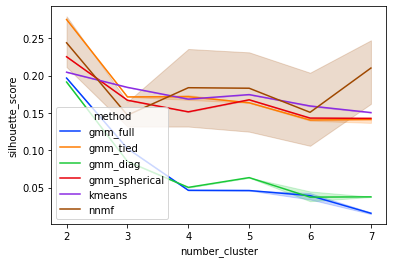

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright') # Close to 1

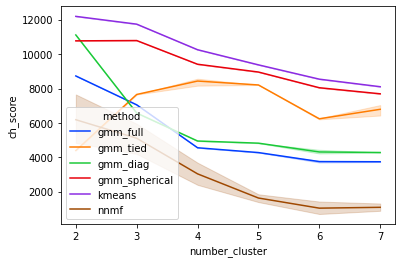

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright') # Maximize

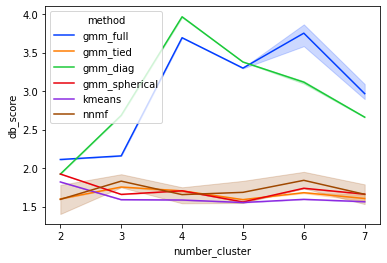

In [ ]:
sns.lineplot(data=df_results, x='number_cluster', y='db_score', hue='method', palette='bright') # close to zero

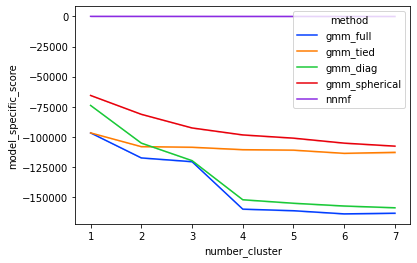

In [ ]:
sns.lineplot(data=df_results[df_results['method']!='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # BIC - Minimize / find elbow

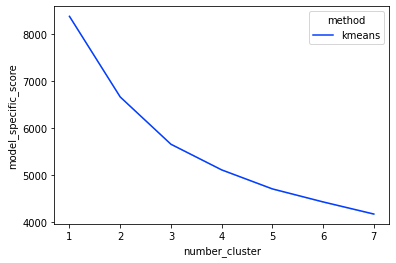

In [ ]:
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

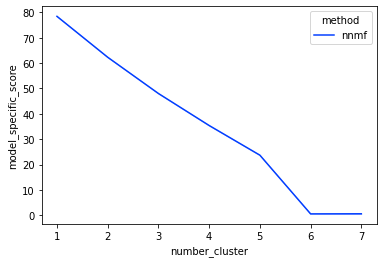

In [ ]:
sns.lineplot(data=df_results[df_results['method']=='nnmf'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

# Calculate Ranking

In [ ]:
df_results_agg[df_results_agg['number_cluster']==2].sort_values(by='silhouette_score_avg', ascending=False)#.iloc[0]

,method,number_cluster,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std
22,gmm_tied,2,0.275340,4394.942444,-108016.070904,1.601763,0.000016,1.451462,0.455354,0.000122
36,nnmf,2,0.244134,6184.834792,62.339000,1.595505,0.059430,2403.512771,0.000426,0.328165
15,gmm_spherical,2,0.225434,10771.152510,-81178.934199,1.925062,0.000119,0.661069,0.927423,0.000416
29,kmeans,2,0.204753,12194.812576,6661.898627,1.821964,0.000438,2.903231,0.007937,0.000982
8,gmm_full,2,0.196877,8730.110616,-117366.116685,2.113217,0.000093,1.186072,1.033894,0.000155
1,gmm_diag,2,0.191538,11113.904476,-105075.240037,1.924023,0.000017,0.268415,0.688384,0.000054


In [ ]:
n_inits = df_results_agg.shape[0] / len(methods)
ranking = []
for i in np.arange(n_inits):
  temp = np.arange(0, len(methods),1).tolist()
  ranking = ranking + temp

In [ ]:
df_ranking = df_results_agg.sort_values(by=['number_cluster', 'silhouette_score_avg'])
df_ranking['ranking_silhouette'] = ranking
df_ranking.sort_values(by=['number_cluster', 'ch_score_avg'], inplace=True)
df_ranking['ranking_ch'] = ranking
df_ranking.sort_values(by=['number_cluster', 'db_score_avg'], inplace=True, ascending=False)
df_ranking['ranking_db'] = ranking
df_ranking = df_ranking.sort_values(by=['number_cluster', 'method']).reset_index(drop=True)
df_ranking['avg_ranking'] = df_ranking[['ranking_silhouette', 'ranking_ch', 'ranking_db']].mean(axis=1)
df_ranking.sort_values(by=['number_cluster', 'avg_ranking'], ascending=False)

,method,number_cluster,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std,ranking_silhouette,ranking_ch,ranking_db,avg_ranking
40,kmeans,7,0.150612,8103.877642,4167.819926,1.565501,0.000255,2.377679,4.683941e-02,0.003409,4,5,5,4.666667
38,gmm_spherical,7,0.142820,7691.817533,-107594.743237,1.663614,0.000308,8.513414,2.647977e+00,0.002200,3,4,2,3.000000
39,gmm_tied,7,0.141251,6790.712819,-112726.103719,1.606888,0.006343,507.266730,1.046905e+03,0.075548,2,3,4,3.000000
41,nnmf,7,0.210305,1091.621429,0.551150,1.661407,0.071850,356.822908,1.635688e-01,0.229703,5,0,3,2.666667
36,gmm_diag,7,0.037647,4278.666154,-158724.301181,2.662757,0.000335,8.043106,5.712877e+00,0.007514,1,2,1,1.333333
37,gmm_full,7,0.015625,3741.234916,-163232.782243,2.967839,0.001853,22.507492,3.226498e+02,0.195003,0,1,0,0.333333
34,kmeans,6,0.159445,8543.158225,4426.046242,1.596263,0.001212,1.181559,1.621224e-01,0.002479,5,5,5,5.000000
32,gmm_spherical,6,0.143241,8044.943409,-105102.225539,1.740227,0.000237,17.369211,9.246535e+00,0.001347,3,4,3,3.333333
33,gmm_tied,6,0.140608,6239.018842,-113570.365951,1.682518,0.001511,53.564939,1.951396e+01,0.013529,2,3,4,3.000000
35,nnmf,6,0.150952,1042.471604,0.515354,1.842773,0.083143,630.625169,7.124410e-02,0.185984,4,0,2,2.000000


In [ ]:
for n in list_n_cluster:
  top = df_ranking[df_ranking['number_cluster'] == n].sort_values(by='avg_ranking', ascending=False).iloc[0]
  print(str(n) + ' Cluster - best method: ' + top['method'] + ' with an average score of ' + str(top['avg_ranking']))

1 Cluster - best method: nnmf with an average score of 5.0
2 Cluster - best method: kmeans with an average score of 3.3333333333333335
3 Cluster - best method: kmeans with an average score of 5.0
4 Cluster - best method: kmeans with an average score of 4.333333333333333
5 Cluster - best method: kmeans with an average score of 4.666666666666667
6 Cluster - best method: kmeans with an average score of 5.0
7 Cluster - best method: kmeans with an average score of 4.666666666666667


# Test Rand Score

In [ ]:
#dict_rand_scores[iteration][number_cluster] - avg_rand_score

In [ ]:
# Create empty dict
dict_rand_scores = {}
for i in np.arange(n_iterations):
  dict_temp = {}
  for n_cluster in list_n_cluster:
    dict_temp.update({n_cluster: np.nan})
  dict_rand_scores.update({i: dict_temp})
dict_rand_scores

{0: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 1: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 2: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 3: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 4: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 5: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 6: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 7: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 8: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 9: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan}}

In [ ]:
# Calc Rand Scores
for i in np.arange(n_iterations):
  random_seed = random_seeds[i]
  for n_cluster in list_n_cluster:
    cum_rand_scores = 0
    for method_1 in methods:
      df_1 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_1 +'_' + str(n_cluster) + '.csv')
      labels_1 = df_1['group'].to_numpy()
      for method_2 in methods:
        df_2 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_2 +'_' + str(n_cluster) + '.csv')
        labels_2 = df_2['group'].to_numpy()
        rand_score = metrics.adjusted_rand_score(labels_1, labels_2)
        
        #print(str(n_cluster) + ' Cluster - Comparing ' + method_1 + ' with ' + method_2 + ' - Rand Score: ' + str(rand_score))
        cum_rand_scores = cum_rand_scores + rand_score
    avg_rand_score = (cum_rand_scores-len(methods)) / ((len(methods)-1)*len(methods))
    dict_rand_scores[i][n_cluster] = avg_rand_score
    print(str(n_cluster) + ' Cluster with average rand score: ' + str(avg_rand_score))

1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.2698119910347387
3 Cluster with average rand score: 0.26971405719173275
4 Cluster with average rand score: 0.2395321149162367
5 Cluster with average rand score: 0.26716452263117085
6 Cluster with average rand score: 0.23696550934958188
7 Cluster with average rand score: 0.27600709192752065
1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.263279061340656
3 Cluster with average rand score: 0.256732274512496
4 Cluster with average rand score: 0.2328876122871298
5 Cluster with average rand score: 0.2546899926586177
6 Cluster with average rand score: 0.23046752706968618
7 Cluster with average rand score: 0.27237638421222704
1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.29209426064363647
3 Cluster with average rand score: 0.2592565139763814
4 Cluster with average rand score: 0.2786214486468964
5 Cluster with average rand score: 0.259951007330053
6 Cluster with 

In [ ]:
# Create DataFrames
df_rand_scores = pd.DataFrame.from_dict(dict_rand_scores)
df_rand_scores['n_cluster'] = df_rand_scores.index
df_rand_scores_plot = pd.melt(df_rand_scores, id_vars='n_cluster')
df_rand_scores_plot.rename(columns={'variable': 'iteration', 'value': 'rand_score'}, inplace=True)
for i in np.arange(n_iterations):
  df_rand_scores.rename(columns={i: 'rand_score_' + str(i)}, inplace=True)
df_rand_scores['avg_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').mean()
df_rand_scores['std_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').std()
df_rand_scores

,rand_score_0,rand_score_1,rand_score_2,rand_score_3,rand_score_4,rand_score_5,rand_score_6,rand_score_7,rand_score_8,rand_score_9,n_cluster,avg_rand_score,std_rand_score
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,0.000000
2,0.269812,0.263279,0.292094,0.269278,0.295076,0.299039,0.253591,0.258554,0.287798,0.298578,2,0.278710,0.017579
3,0.269714,0.256732,0.259257,0.254882,0.258412,0.262094,0.318164,0.253628,0.260178,0.287944,3,0.268101,0.020240
4,0.239532,0.232888,0.278621,0.227740,0.240889,0.207682,0.249984,0.225644,0.232442,0.275895,4,0.241132,0.022052
5,0.267165,0.254690,0.259951,0.257402,0.263836,0.244246,0.250168,0.251695,0.259939,0.270084,5,0.257918,0.007980
6,0.236966,0.230468,0.238332,0.249079,0.245123,0.232511,0.227268,0.226865,0.238691,0.248071,6,0.237337,0.008153
7,0.276007,0.272376,0.288725,0.274268,0.273505,0.251240,0.274308,0.271866,0.227158,0.294234,7,0.270369,0.018910


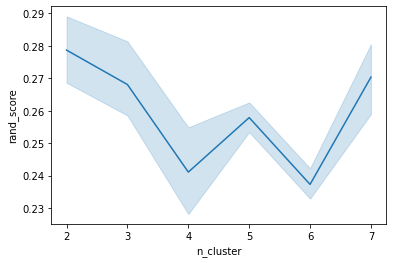

In [ ]:
sns.lineplot(data=df_rand_scores_plot[df_rand_scores_plot['n_cluster'] != 1], x='n_cluster', y='rand_score', palette='bright')